### Create warming stripes for the weather station "Stockholm" over time to inspect warming over time

Tips: Use the year, yearly average temp to create warming stripes showing the change in average temperature over time

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap
import numpy as np
from sqlalchemy import create_engine, text

In [5]:
from dotenv import dotenv_values

config = dotenv_values(".env")

In [6]:
# define variables for the login
username = config['USER']
password = config['PASS']
host = config['HOST']
port = config['PORT']

In [7]:
url = f'postgresql://{username}:{password}@{host}:{port}/climate'

In [8]:
engine = create_engine(url, echo=False)

In [9]:
with engine.begin() as conn:
    results = conn.execute(text("""
SELECT  s.staname AS station_name, 
        s.staid AS station_id,
        ymt.yearly_temp AS mean_temp,
        ymt.year AS year
FROM stations s
INNER JOIN yearly_mean_temperature ymt ON ymt.staid = s.staid
ORDER BY year
"""))

data = results.fetchall()
df_warming_stripes = pd.DataFrame(data)

In [10]:
df_warming_stripes

,station_name,station_id,mean_temp,year
0,STOCKHOLM,10,0E-20,1756
1,VARTAN,5465,0E-20,1756
2,STOCKHOLM_A,5464,0E-20,1756
3,STOCKHOLM_A,5464,0E-20,1757
4,VARTAN,5465,0E-20,1757
...,...,...,...,...
250574,TETEROW,4676,66.1125827814569536,2023
250575,PUCH,4530,62.8543046357615894,2023
250576,MALLERSDORF-PFAFFENBERG,4842,63.7682119205298013,2023
250577,QUEDLINBURG,4534,73.7284768211920530,2023


In [11]:
#to find the station with largest timeframe
min_max_years = df_warming_stripes.groupby('station_name')['year'].agg(['min', 'max'])

# Calculate the timeframe for each station
min_max_years['timeframe'] = min_max_years['max'] - min_max_years['min']

# Convert the 'timeframe' column to numeric data type (optional, but ensures proper calculations)
min_max_years['timeframe'] = pd.to_numeric(min_max_years['timeframe'])

# Find the station with the largest timeframe
largest_timeframe_station = min_max_years.loc[min_max_years['timeframe'].idxmax()]

print(largest_timeframe_station)

min           1756
max           2023
timeframe    267.0
Name: STOCKHOLM                                   , dtype: object


In [12]:
df_station_ws = df_warming_stripes[df_warming_stripes['station_id']== 10]
df_station_ws

,station_name,station_id,mean_temp,year
0,STOCKHOLM,10,0E-20,1756
5,STOCKHOLM,10,0E-20,1757
6,STOCKHOLM,10,0E-20,1759
11,STOCKHOLM,10,0E-20,1760
12,STOCKHOLM,10,0E-20,1762
...,...,...,...,...
237330,STOCKHOLM,10,86.0301369863013699,2019
241316,STOCKHOLM,10,97.2131147540983607,2020
244622,STOCKHOLM,10,81.4054794520547945,2021
247445,STOCKHOLM,10,87.7068493150684932,2022


1. Choose a baseline period:  1756-2023
2. Calculate average temperature during the baseline, add all the temperatures recorded during these years and  divide the sum by the number of years. 
3. Calculate anomalies: Anomaly is the difference between the observed value and the average value during the baseline period. 
    - Subtract the baseline average temp from the observed mean temp, which represents how much the observed temperature deviates from the average baseline temperature.
    - If the observed value is higher than the baseline average, the anomaly will be positive, indicating that the value is above the average.
    - If the observed value is lower than the baseline average, the anomaly will be negative, indicating that the value is below the average.rage.

In [13]:
# Convert the 'mean_temp' column to a float data type using .loc
df_station_ws.loc[:, 'mean_temp'] = df_station_ws['mean_temp'].astype(float)

# Calculate the baseline average
baseline_start = 1756
baseline_end = 2023
baseline_mean_temp = df_station_ws[(df_station_ws['year'] >= baseline_start)
                    & (df_station_ws['year'] <= baseline_end)]['mean_temp'].mean()

# Convert the baseline_mean_temp to a float data type
baseline_mean_temp = float(baseline_mean_temp)

# Calculate temperature anomalies using .loc
df_station_ws.loc[:, 'temp_anomaly'] = df_station_ws['mean_temp'] - baseline_mean_temp

C:\Users\HP\AppData\Local\Temp\ipykernel_11772\4196969332.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_station_ws.loc[:, 'temp_anomaly'] = df_station_ws['mean_temp'] - baseline_mean_temp


In [14]:
#thanks to chatgpt

# There was invalid data and NaN in the 'temp_anomaly' column that was causing issues with the colormap normalization

# converted the 'temp_anomaly' column to a numeric format before using np.isfinite() 

# Convert the 'temp_anomaly' column to a numeric format (float)
df_station_ws['temp_anomaly'] = pd.to_numeric(df_station_ws['temp_anomaly'], errors='coerce')

# Filter out rows with NaN values in 'temp_anomaly' column - removing invalid data
df_station_ws = df_station_ws.dropna(subset=['temp_anomaly'])

# Convert 'temp_anomaly' column to a NumPy array to ensure compatibility with the colormap normalization function.
temp_anomaly_values = df_station_ws['temp_anomaly'].values

C:\Users\HP\AppData\Local\Temp\ipykernel_11772\3277044604.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_station_ws['temp_anomaly'] = pd.to_numeric(df_station_ws['temp_anomaly'], errors='coerce')


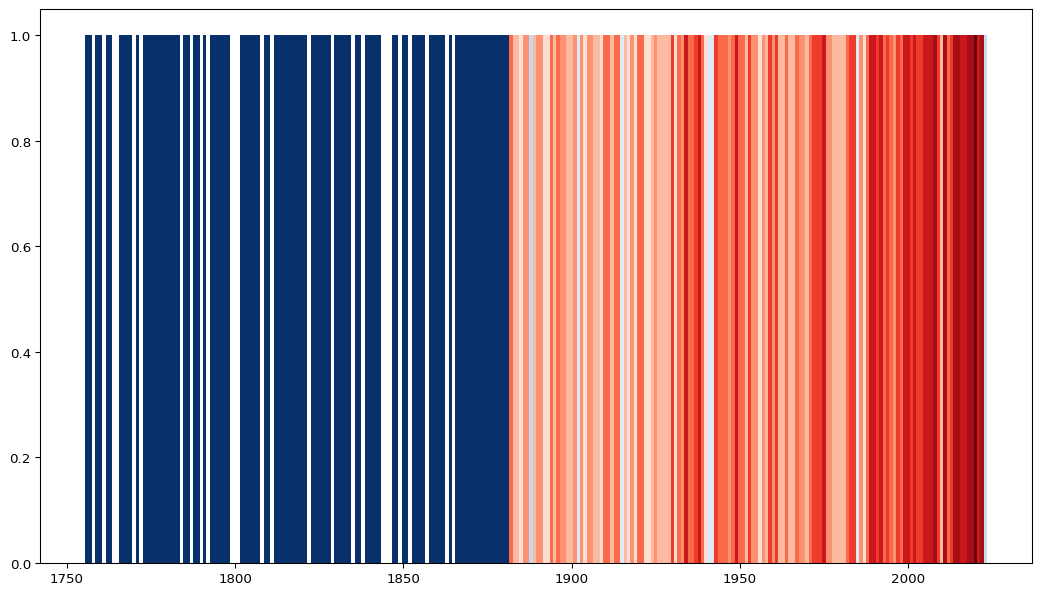

In [15]:
# Create the figure and axes objects, specify the size and the dots per inches
fig, ax = plt.subplots(figsize=(13.33, 7.5), dpi=96)

# Colours - Choose the colour map - 8 blues and 8 reds
cmap = ListedColormap([
    '#08306b', '#08519c', '#2171b5', '#4292c6',
    '#6baed6', '#9ecae1', '#c6dbef', '#deebf7',
    '#fee0d2', '#fcbba1', '#fc9272', '#fb6a4a',
    '#ef3b2c', '#cb181d', '#a50f15', '#67000d'])

# linearly normalizes data into the [0.0, 1.0] interval
norm = mpl.colors.Normalize(np.min(temp_anomaly_values), np.max(temp_anomaly_values))

# Plot bars
bar = ax.bar(df_station_ws['year'], 1, color=cmap(norm(temp_anomaly_values)), width=1, zorder=2)

source: https://towardsdatascience.com/visualizing-climate-change-a-step-by-step-guide-to-reproduce-climate-stripes-with-python-ea1d440e8e8d

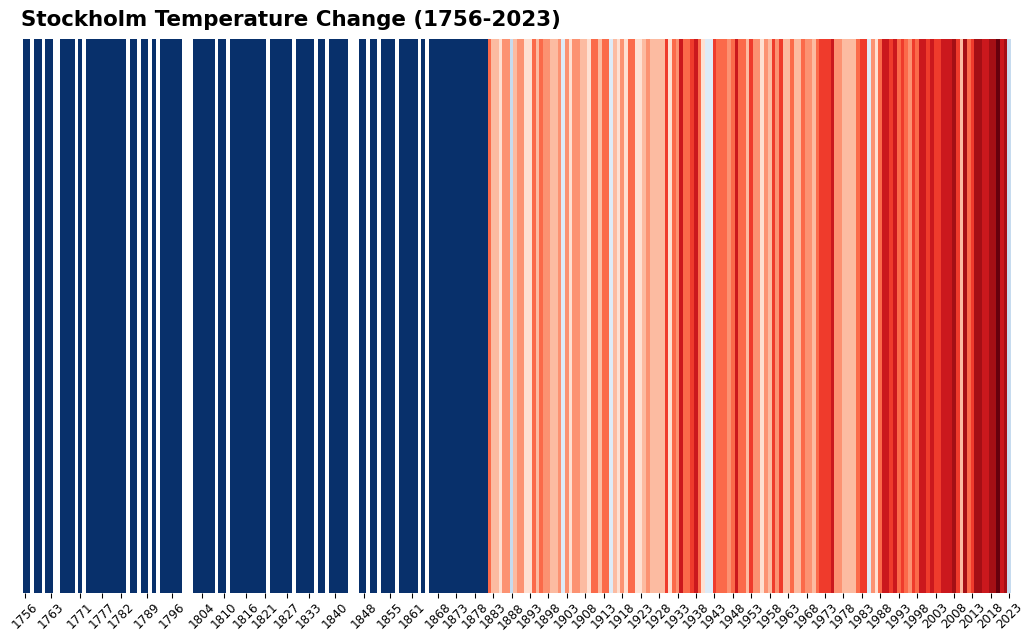

In [20]:
# Create the figure and axes objects, specify the size and the dots per inches
fig, ax = plt.subplots(figsize=(13.33, 7.5), dpi=96)

# Colours - Choose the colour map - 8 blues and 8 reds
cmap = ListedColormap([
    '#08306b', '#08519c', '#2171b5', '#4292c6',
    '#6baed6', '#9ecae1', '#c6dbef', '#deebf7',
    '#fee0d2', '#fcbba1', '#fc9272', '#fb6a4a',
    '#ef3b2c', '#cb181d', '#a50f15', '#67000d'])

# linearly normalizes data into the [0.0, 1.0] interval
norm = mpl.colors.Normalize(np.min(temp_anomaly_values), np.max(temp_anomaly_values))

# Plot bars
bar = ax.bar(df_station_ws['year'], 1, color=cmap(norm(temp_anomaly_values)), width=1, zorder=2)

# Remove the spines
ax.spines[['top', 'left', 'bottom', 'right']].set_visible(False)

# Reformat y-axis label and tick labels
ax.set_ylabel('', fontsize=12, labelpad=10)
ax.set_yticks([])
ax.set_ylim([0, 1])

# Reformat x-axis label and tick labels
ax.set_xlabel('', fontsize=12, labelpad=10)
ax.xaxis.set_tick_params(pad=2, labelbottom=True, bottom=True, labelsize=9, labelrotation=45, labelcolor='black')
ax.set_xlim([df_station_ws['year'].min() - 1, df_station_ws['year'].max() + 1])

# Set graph title
ax.set_title('Stockholm Temperature Change (1756-2023)', loc='left', color='black', fontweight="bold", size=16, pad=10)

# Adjust the x-axis tick labels to show every few years
tick_step = 5
xticks = df_station_ws['year'][::tick_step]
ax.set_xticks(xticks)

# Set background
fig.patch.set_facecolor('white')
ax.patch.set_facecolor('white')

plt.show()